In [ ]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Chuẩn bị data

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Đường dẫn tới dữ liệu gốc và nơi lưu trữ dữ liệu đã chia
data_dir = '/content/drive/MyDrive/human_data_for_classification'
train_dir = '/content/drive/MyDrive/human_data_for_classification/train'
val_dir = '/content/drive/MyDrive/human_data_for_classification/val'

# Tạo thư mục cho train và val nếu chưa có
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(os.path.join(train_dir, 'human'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'nonhuman'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'human'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'nonhuman'), exist_ok=True)

# Danh sách các thư mục cần chia
categories = ['human', 'nonhuman']

for category in categories:
    category_path = os.path.join(data_dir, category)
    files = os.listdir(category_path)
    files = [os.path.join(category_path, f) for f in files]

    # Chia dữ liệu thành train và val
    train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)

    # Di chuyển các file vào thư mục train và val tương ứng
    for file in train_files:
        shutil.move(file, os.path.join(train_dir, category, os.path.basename(file)))
    for file in val_files:
        shutil.move(file, os.path.join(val_dir, category, os.path.basename(file)))

print("Data has been split and moved successfully.")



Load data

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
data_dir = '/content/drive/MyDrive/human_data_for_classification'
# Định nghĩa các biến đổi cho ảnh
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Tải dữ liệu và áp dụng biến đổi
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

# Tạo DataLoader
train_loader = DataLoader(image_datasets['train'], batch_size=32, shuffle=True)
val_loader = DataLoader(image_datasets['val'], batch_size=32, shuffle=False)

#xem kích thước ảnh đầu vào
images, labels = next(iter(train_loader))
print(images.size())


torch.Size([32, 3, 150, 150])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 9 * 9, 512)  # Adjust based on image size after conv layers
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Khởi tạo mô hình
model = CNNModel()


In [ ]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Hàm tính toán accuracy
def calculate_accuracy(outputs, labels):
    preds = outputs.round()  # Chuyển xác suất thành 0 hoặc 1
    correct = (preds == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

# Hàm huấn luyện
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += calculate_accuracy(outputs, labels) * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects / len(dataloaders['train'].dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += calculate_accuracy(outputs, labels) * inputs.size(0)

        val_epoch_loss = val_running_loss / len(dataloaders['val'].dataset)
        val_epoch_acc = val_running_corrects / len(dataloaders['val'].dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)

        print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

    torch.save(model.state_dict(), '/content/drive/My Drive/model.pth')
    return train_losses, val_losses, train_accuracies, val_accuracies

# Huấn luyện mô hình
dataloaders = {'train': train_loader, 'val': val_loader}
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, dataloaders, criterion, optimizer, num_epochs=20)


Epoch 0/19, Train Loss: 0.4420, Train Acc: 0.7677, Val Loss: 0.3241, Val Acc: 0.8555
Epoch 1/19, Train Loss: 0.2096, Train Acc: 0.9192, Val Loss: 0.1498, Val Acc: 0.9364
Epoch 2/19, Train Loss: 0.1433, Train Acc: 0.9474, Val Loss: 0.1009, Val Acc: 0.9605
Epoch 3/19, Train Loss: 0.1137, Train Acc: 0.9583, Val Loss: 0.0935, Val Acc: 0.9644
Epoch 4/19, Train Loss: 0.0787, Train Acc: 0.9723, Val Loss: 0.0708, Val Acc: 0.9740
Epoch 5/19, Train Loss: 0.0613, Train Acc: 0.9807, Val Loss: 0.0622, Val Acc: 0.9721
Epoch 6/19, Train Loss: 0.0557, Train Acc: 0.9809, Val Loss: 0.0370, Val Acc: 0.9913
Epoch 7/19, Train Loss: 0.0439, Train Acc: 0.9846, Val Loss: 0.0308, Val Acc: 0.9904
Epoch 8/19, Train Loss: 0.0307, Train Acc: 0.9904, Val Loss: 0.0355, Val Acc: 0.9846
Epoch 9/19, Train Loss: 0.0283, Train Acc: 0.9896, Val Loss: 0.0217, Val Acc: 0.9923
Epoch 10/19, Train Loss: 0.0252, Train Acc: 0.9920, Val Loss: 0.0363, Val Acc: 0.9865
Epoch 11/19, Train Loss: 0.0180, Train Acc: 0.9949, Val Loss: 0.

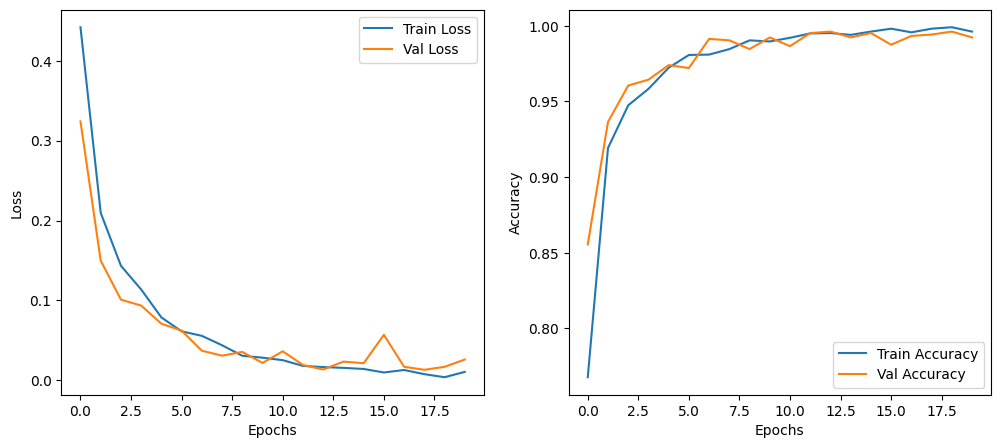

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
epochs = range(20)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Inference**


1.0


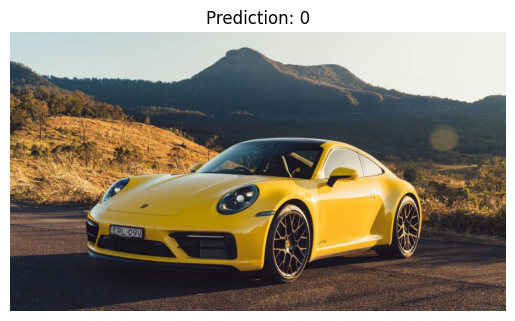

In [ ]:
import requests
from PIL import Image
from io import BytesIO
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Định nghĩa biến đổi
data_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 9 * 9, 512)  # Adjust based on image size after conv layers
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Tạo mô hình mới
model = CNNModel()

# Tải trạng thái mô hình vào mô hình mới
model.load_state_dict(torch.load('/content/drive/MyDrive/model.pth'))

# Đặt mô hình ở chế độ đánh giá
model.eval()

# Đường dẫn ảnh
image_path = '/content/PORSCHE_TAYCANGTS_911.jpg.webp'

# Mở ảnh từ đường dẫn
image = Image.open(image_path)

# Hàm dự đoán cho một ảnh
def predict_image(image):
    image = data_transform(image)
    image = image.unsqueeze(0)  # Thêm một chiều batch
    with torch.no_grad():
        outputs = model(image)
        prediction = outputs.item()  # Trả về xác suất dự đoán
        predicted_label = 1 if prediction < 0.5 else 0
    return predicted_label

# Dự đoán cho ảnh từ URL
prediction = predict_image(image)
plt.imshow(image)
plt.title(f'Prediction: {prediction}')
plt.axis('off')  # Tắt trục
plt.show()
